In [1]:
# Copyright 2016-present, Facebook, Inc.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE-examples file in the root directory of this source tree.

# Intro to Sampling

The question we will ask is: **Given a population, what percent of the population is a positive example?**

*This assumes that we don't know if something is positive or negative in advice!* If we know the answer to this up front or it is easily understood then there is no point in sampling. We have to take the sample because we are interested in identifying some attribute but the evaluation is expensive.

First we will demonstrate how this code can be used to take a normal random sample.

Then, we will study our question when the importance weight of each record is different:
1. Using regular random sampling
1. Using importance weighted sampling
1. Using full model assisted sampling

In [1]:
import ml_sampler
import numpy as np

## The population

In [2]:
population_size = 1000000

# 1.0% of the population is a 'positive' example
is_positive = np.random.random(population_size) < 0.01

# Note: predetermining 'is_positive' is necessary for 
# the purposes of this example.
# In a real application we would have to sample - then determine
# if the record is positive or not. 

In [3]:
print 'Positive Volume', is_positive.sum() 
print 'Positive Percent', is_positive.sum() * 100.0 / len(is_positive) 

Positive Volume 9971
Positive Percent 0.9971


## Simple random sampling using ml_sampler

In [4]:
random_weights = np.ones(population_size)
random_biases = np.ones(population_size)

random_index, random_p_sample = ml_sampler.biased_sample(
    biases=random_biases, # same bias for each record (no bias)
    weights=random_weights, # weight each record equally
    num_samples=2000
)


est_pos_volume = ml_sampler.estimator(
    random_weights[random_index], 
    random_p_sample, 
    is_positive[random_index],
)


print 'Est. Positive Volume', est_pos_volume
print 'Est. Positive Percent', est_pos_volume * 100.0 / len(is_positive)

Est. Positive Volume 11500.0
Est. Positive Percent 1.15


## Sampling with importance weights!

In [5]:
# assign different weights to each record. 
# for example, if we cared about the overall prevalence of spam - 
#    this could represent number of times a piece of potential spam was seen  
importance_weights = np.random.exponential(scale=100, size=population_size)

In [6]:
weighted_pos_volume = importance_weights[is_positive].sum()
print 'Weighted Positive Volume', weighted_pos_volume
print 'Weighted Positive Percent', weighted_pos_volume * 100.0 / importance_weights.sum()

Weighted Positive Volume 994584.162379
Weighted Positive Percent 0.99328617491


### Random Sampling

In [7]:
# do regular random sampling then sum the importance weights at the end
# this is similar to the above example but now we have to account for importance

random_sample_index, random_sample_p_sample = ml_sampler.biased_sample(
    # same bias for each record
    biases=np.ones(population_size), 
    weights=np.ones(population_size),
    num_samples=2000
)

# represents the size of each record, we didn't account for this in the sampling process
random_sample_weight = importance_weights[random_sample_index]
random_sample_is_positive = is_positive[random_index]

est_pos_volume = ml_sampler.estimator(
    random_sample_weight, 
    random_sample_p_sample, 
    random_sample_is_positive,
)

print 'Est. Weighted Positive Volume', est_pos_volume
print 'Est. Weighted Positive Percent', est_pos_volume * 100.0 / importance_weights.sum()

Est. Weighted Positive Volume 1067632.06243
Est. Weighted Positive Percent 1.0662387434


### Probability Proportionate to Size (PPS) Sampling / Weighted sampling

In [8]:
pps_index, pps_p_sample = ml_sampler.biased_sample(
    # same bias for each record
    biases=np.ones(population_size), 
    # now we sample with our importance weights
    weights=importance_weights,
    num_samples=2000
)

pps_weights = importance_weights[pps_index]
pps_is_positive = is_positive[pps_index]

est_pos_volume = ml_sampler.estimator(
    pps_weights, 
    pps_p_sample,
    pps_is_positive,
)

print 'Est. Weighted Positive Volume', est_pos_volume
print 'Est. Weighted Positive Percent', est_pos_volume * 100.0 / importance_weights.sum()

Est. Weighted Positive Volume 851110.746708
Est. Weighted Positive Percent 0.85


## Cool story. 

But why should you care about PPS Sampling vs the Regular sampling? 

Well, it turns out that these two methods are NOT equal. The PPS sampling method is generally better because it produces a more accurate estimate - the error of the samples taken is less.

Lets do some simulations to prove this out!

In [9]:
random_percent_positive = []
for _ in range(3000):
    random_sample_index, random_sample_p_sample = ml_sampler.biased_sample(
        # same bias for each record
        biases=np.ones(population_size), 
        weights=np.ones(population_size),
        num_samples=2000
    )

    # represents the size of each record, we didn't account for this in the sampling process
    random_sample_weight = importance_weights[random_sample_index]
    random_sample_is_positive = is_positive[random_sample_index]

    est_pos_volume = ml_sampler.estimator(
        random_sample_weight, 
        random_sample_p_sample, 
        random_sample_is_positive,
    )
    
    percent_positive = est_pos_volume * 100.0 / importance_weights.sum()
    
    random_percent_positive.append(percent_positive)

In [10]:
pps_percent_positive = []
for _ in range(3000):
    pps_index, pps_p_sample = ml_sampler.biased_sample(
        # same bias for each record
        biases=np.ones(population_size), 
        # now we sample with our importance weights
        weights=importance_weights,
        num_samples=2000
    )

    pps_weights = importance_weights[pps_index]
    pps_is_positive = is_positive[pps_index]

    est_pos_volume = ml_sampler.estimator(
        pps_weights, 
        pps_p_sample,
        pps_is_positive,
    )
    
    percent_positive = est_pos_volume * 100.0 / importance_weights.sum()
    
    pps_percent_positive.append(percent_positive)

In [11]:
print 'Random estimate of weighted percent positive {0:0.2f}'.format(np.percentile(random_percent_positive, 50))
print '\t95% confidence interval ({0:0.2f}, {1:0.2f})'.format(*np.percentile(random_percent_positive, [2.5, 97.5]))
print
print 'PPS estimate of weighted percent positive {0:0.2f}'.format(np.percentile(pps_percent_positive, 50))
print '\t95% confidence interval ({0:0.2f}, {1:0.2f})'.format(*np.percentile(pps_percent_positive, [2.5, 97.5]))

Random estimate of weighted percent positive 0.98
	95% confidence interval (0.44, 1.71)

PPS estimate of weighted percent positive 1.00
	95% confidence interval (0.60, 1.40)


Ahhh! So we see that the importance estimate typically produces narrower confidence intervals. 

**Question?** Can we do any better than this?

**Answer?** Well, it depends. With importance sampling we were able to take into account the additional information we had about the importance values up front. What if we also had some approximate information about the chances of something being positive? We should be able to use that information too. 

### Model Assisted Sampling
Lets say that we have some additional information for each record. For example, suppose we know up front the probability that a record will be positive (but not specifically if it IS positive). We can use this information to our advantage. 

In practice we may build a machine learning model that produces scores for each record (does not actually have to be a true probability). We can use this new information to our advantage!

In [12]:
# create some scores for each record where the score is correlated
# with is_positive - this is a stand in for a real ML model
scores = np.zeros(population_size)
scores[is_positive] = np.random.normal(loc=2.9, scale=0.3,
                                       size=is_positive.sum())

scores[~is_positive] = np.random.normal(loc=0.8, scale=1.0,
                                        size=(~is_positive).sum())
scores -= scores.min() 
scores += 0.0001

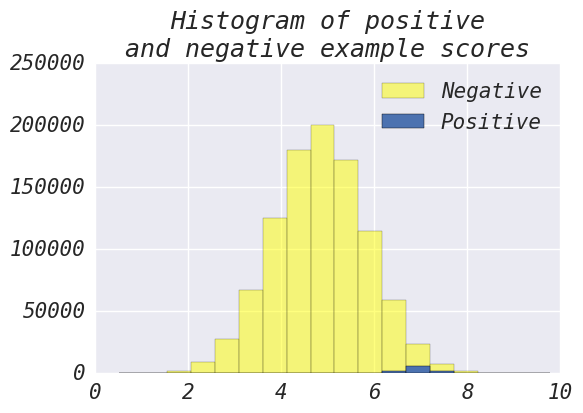

In [13]:
scores_df = pd.DataFrame({'scores': scores, 'is_positive': is_positive})

bins = np.linspace(scores.min(), scores.max(), 20)

ax = scores_df[~scores_df.is_positive].scores.hist(label='Negative', alpha=0.5, bins=bins, color='yellow')
scores_df[scores_df.is_positive].scores.hist(ax=ax, label='Positive', alpha=1.0, bins=bins)

plt.legend()
plt.title('Histogram of positive\nand negative example scores')

In [14]:
ml_index, ml_p_sample = ml_sampler.biased_sample(

    # Bias the sample towards according to scores. This method will
    # over sample things with higher scores but those
    # samples will be weighted less.
    # Example:
    #     scores[1] == 10
    #     scores[2] == 1
    #   All else being equal:
    #    record[1] should be sampled 10x more frequently than record[2]
    #    record[1] will count for 1/10th the weight of record[2]
    biases=scores, 
    
    weights=importance_weights, 
    num_samples=2000
)

In [15]:
ml_is_positive = is_positive[ml_index]
ml_weights = importance_weights[ml_index]

est_pos_volume = ml_sampler.estimator(
    ml_weights, 
    ml_p_sample,
    ml_is_positive,
)

print 'Est. Weighted Positive Volume', est_pos_volume
print 'Est. Weighted Positive Percent', est_pos_volume * 100.0 / importance_weights.sum()

# We get ~50% more positive samples with ml_sampler
print 'Percent of Positive Samples Taken', ml_is_positive.mean() * 100.0

Est. Weighted Positive Volume 1058785.03834
Est. Weighted Positive Percent 1.05740326517
Percent of Positive Samples Taken 1.5


In [16]:
ml_percent_positive = []

for _ in range(3000):
    ml_index, ml_p_sample = ml_sampler.biased_sample(
        biases=scores,  
        weights=importance_weights,         
        num_samples=2000
    )
    
    ml_is_positive = is_positive[ml_index]
    ml_weights = importance_weights[ml_index]

    est_pos_volume = ml_sampler.estimator(
        ml_weights, 
        ml_p_sample,
        ml_is_positive,
    )
    
    percent_positive = est_pos_volume * 100.0 / importance_weights.sum()
    
    ml_percent_positive.append(percent_positive)

In [17]:
print 'Random estimate of weighted percent positive {0:0.2f}'.format(np.percentile(random_percent_positive, 50))
print '\t95% confidence interval ({0:0.2f}, {1:0.2f})'.format(*np.percentile(random_percent_positive, [2.5, 97.5]))
print

print 'PPS estimate of weighted percent positive {0:0.2f}'.format(np.percentile(pps_percent_positive, 50))
print '\t95% confidence interval ({0:0.2f}, {1:0.2f})'.format(*np.percentile(pps_percent_positive, [2.5, 97.5]))
print

print 'ML estimate of weighted percent positive {0:0.2f}'.format(np.percentile(ml_percent_positive, 50))
print '\t95% confidence interval ({0:0.2f}, {1:0.2f})'.format(*np.percentile(ml_percent_positive, [2.5, 97.5]))
print


Random estimate of weighted percent positive 0.98
	95% confidence interval (0.44, 1.71)

PPS estimate of weighted percent positive 1.00
	95% confidence interval (0.60, 1.40)

ML estimate of weighted percent positive 0.99
	95% confidence interval (0.66, 1.36)



### Analysis
Random, Importance, and ML all produce reasonable estimations of the true prevalence. In this example - ML Assisted  has the tightest confidence interval and is more accurate than the other methods. Additionally, ML Assisted gives us ~50% more positive samples.